## Overview

In this notebook, the data of about 6,000 ICU patients are loaded into a data frame. 8 columns are dedicated to vital signs, 26 to laboratory results, and 9 to demographic data. The meanings of each column from the raw data are [given here](https://physionet.org/content/challenge-2019/1.0.0/) and my own notes are available in the *Notes* dictionary.

__Additions__: 2 demographic columns are added to the original data set, which are:

    -'id': integer specifying unique patient id for each time point related to that patient
    -'HospitalA': 1 or 0 if patient was at Hopsital A or B, respectively

__Changes__: The following columns had some outliers & incorrect values changed to NaNs

    -'FiO2'
    -'Temp' 
    -'DBP'
    -'SBP'
    -'MAP'
    
The following lab value columns had outliers truncated (replaced with a more common value). 

    -Alkalinephos
    -Potassium
    -TroponinI
    -WBC
    
Filled nans with 0s in Unit1 & Unit2 columns.

Overall the data seems to be in good shape; there is a healthy number of data points available for all patients.**The chief concern is the range and values of some of the vital signs column, as discussed below.**

__Results__: Interim data is saved in the /data/interim folder of this project as 'sepsis_data_cleaned.csv'. A copy of the Pandas Profiling Report is saved in the /notebooks folder. Notes for each column stored in *Notes* dictionary, 

## Discussion

Given that the data came from a well organized competion, all the data needed to build a sepsis predicition model is available. Sepsis Label is the target value.

6/8 of the vital fields have values for almost all patients, and they will most certainly be key in assessing the patient's state. 10 laboratory field values are available for at least 80% of patients. Some fields have no data for many of the patients, but this is not surprising as not all substances would be checked for in the blood by default - some are only asked for by the clinician if they suspect the patient is suffering from a particular problem, such as TroponinI in patients who are suspected to have had/soon have a heart attack. The lack of laboratory values in some patients may actually be helpful in accurately classifying sepsis.

I interviewed a former SICU nurse of 25+ years for insight into how physiological data is used in the SICU. She said that one data point doesn't matter all that much to clinicians- its the trend overtime, as well as the culmiation of data points that they act on. Furthermore, a living patient can have a data point that one would think couldn't support human life - e.g. an O2sat of 50% in a COVID patient - because their body has had time to adapt to the condition. So, just because a data point is very extreme doesn't necessarily mean it's an error.

There are two important distinctions between the laboratory values and the vital signs that will influence how the data is cleaned. Firstly, laboratory values are collected in controlled lab environments with assumably reliable equipment. Secondly, in some patients, values are possible that are a vastly different scale that the average value, likely due to the presence of disease. For example, the median value of Alkalinephos in the data set is 75 IU/L, which is in line with a range of 20 to 140 IU/L for healthy patients. In this data set, the patient with the highest Alkalinephos value has two lab results of 2121.0 and 1919.0 IU/L which are more than 25x greater than the median. Furthermore, these data points are quite isolated, with the patient with the next highest result having a value of 1204.0 IU/L. Nonetheless, the patient having a maxmimum value of 2121.0 is plausble, as I found a paper that reported up to 3,360: [Source Here](https://pubmed.ncbi.nlm.nih.gov/9855266/).

In contrast, vital signs are collected via sensors placed on/in the patient. The sensors could loose contact with the patient overtime. Furthermore, there are some values that are known not compatible with human life - a heart rate of 1 or 1000, a temperature of 10 or 50 degrees celsius. It should also be considered that the accuracy of a sensor can diminish when the biological signal moves out of a typical range; for example, pulse oximeters perform well when O2 Sat values are  within the 90-100% range, but their accuracy drops off at lower values.

In all, it would be hard to justify removing any laboratory value outliers of concentration of a substance in the blood. It is easier to justify the removal of some vital sign data points, though for they moment they are mostly flagged. Specific investigations and changes are commented on below.

__Vital Signs__
Heart Rate and EtCO2 ranges completely plausible. Temperature had a few extreme values above 45 and below 30 that were marked as NaN.
Respiration and O2 Sats have low values seem suspect, but they are left as is for now. 
There are 3, related fields for blood pressure - DBP, SBP, MAP. In instances where DBP was greater than or equal to SBP, all BP values were marked as NaN. MAP is related to DBP & SBP with a simple arithmetic relation at low HR values, but can change at higher values. I did not make any changes if calculated MAP did not reasonably line up with DBP & SBP values, but they are suspect.


__Labratory Values__
Though I haven't checked every laboratory value range, they generally seem plausible - e.g. here glucose ranges from 14 to 924 mg/dl, and apparently the greatest ever recorded blood glucose level was 2656 mg/dl: [Source Here](https://www.guinnessworldrecords.com/world-records/highest-blood-sugar-level/?fb_comment_id=811257658947726_974655159274641#:~:text=Michael%20Patrick%20Buonocore%20(USA)%20(,%2D120%20mg%2Fdl).). The only value that was modifed was FiO2, which is a fraction but had a few values greater than 1. They where changed to NaN.
If just a handful of outliers really distorted the distribution (e.g. doubling the x scale), then I truncated the values, replacing them with lower ones closer to the mean.

__Demographic Data__
All check out except for HospAdmTime. Some extreme outliers here that don't make sense- 3,200 hours between hospital admit and ICU admit is about 1/3 of a year. Not sure what to do with this at this point. It is left as is for now, but perhaps something to revisit.

__Missingness__
Hospital B seems is missing a lot more laboratory values than Hospital A. Hospital B is also responsible for all the missing Diastolic Blood Pressure values. Something to keep in mind.

## Code Navigation
* [1. Import](#1.Import)
* [2. Data Collection](#2.DataCollection)
* [3. Data Definition ](#3.DataDefinition)
    * [3.a General Data Characterization](#3.a.GeneralDataCharacterization)
    * [3.b Distributions - Raw](#3.b.Distributions-Raw)
    * [3.c Characterizing Missingness](#3.c.CharacterizingMissingness) 
* [4. Data Cleaning](#4.DataCleaning)
    * [4.a Exploring Vital Signs](#4.a.ExploringVitalSigns)
    * [4.b Exploring Lab Values](#4.b.ExploringLabValues)
    * [4.c Exploirng Demographic Info](#4.c.ExploringDemographicInfo)
    * [4.d Distributions - Modified](#4.d.Distributions-Modified)
* [5. Data Export](#5.DataExport)

## 1. Import <a class="anchor" id="1.Import"></a>

In [1]:
import glob, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
import operator
import seaborn as sns
#from pandas_profiling import ProfileReport
from collections import defaultdict

## 2. Data Collection<a class="anchor" id="2.DataCollection"></a>

In [2]:
os.chdir("../data/raw")

In [3]:
#Code Adapted From
#https://www.kite.com/python/answers/how-to-make-a-single-pandas-dataframe-from-multiple-%60.csv%60-files-in-python
#Accessed February 17th, 2021

#Load data set A into a dataframe
#Add patient number column

i=0
id=[]
df_listA=[]
for file in glob.glob("training_setA/*.psv"):
    id.append(i)
    df_=pd.read_csv(file,sep='|')
    df_['id']=id[i]
    df_['HospitalA']=1
    df_listA.append(df_)
    i=i+1
rawA=pd.concat(df_listA).reset_index(drop=True)
rawA.shape

(128393, 43)

In [4]:
#Load data set B into a df, concatenate with previous df
#Continue patient numbering scheme

df_listB=[]
for file in glob.glob("training_setB/*.psv"):
    id.append(i)   
    
    df_=pd.read_csv(file,sep='|')
    df_['id']=id[i]
    df_['HospitalA']=0
    df_listB.append(df_)
    i=i+1
rawB=pd.concat(df_listB)
raw=pd.concat([rawA,rawB]).reset_index(drop=True)
raw_copy=raw.copy()
raw.shape

(231307, 43)

In [5]:
raw=raw_copy.copy()

## 3. Data Definition<a class="anchor" id="3.DataDefinition"></a>

### 3.a General Data Characterization<a class="anchor" id="3.a.GeneralDataCharacterization"></a>

In [6]:
#Write Pandas Profiling Report
#profile = ProfileReport(raw, title="Raw Data Profile")
#os.chdir('../..')
#os.chdir('notebooks')
#profile.to_file("PandasProfilingReport.html")

In [7]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231307 entries, 0 to 231306
Data columns (total 43 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HR                208443 non-null  float64
 1   O2Sat             201090 non-null  float64
 2   Temp              78444 non-null   float64
 3   SBP               196893 non-null  float64
 4   MAP               202428 non-null  float64
 5   DBP               154610 non-null  float64
 6   Resp              196272 non-null  float64
 7   EtCO2             8128 non-null    float64
 8   BaseExcess        14093 non-null   float64
 9   HCO3              10497 non-null   float64
 10  FiO2              20602 non-null   float64
 11  pH                17453 non-null   float64
 12  PaCO2             13842 non-null   float64
 13  SaO2              8667 non-null    float64
 14  AST               3801 non-null    float64
 15  BUN               16168 non-null   float64
 16  Alkalinephos      37

Most data types are what you'd expect - floats for physiological data, int64 for most demographic data. The Unit1 and Unit2 columns should be int because values are coded as 0 or 1; however, there are a lot of NaNs, so must leave as is.

In [8]:
#Summary statistics for numerical features
raw.describe().drop(labels=['HospitalA','id'],axis=1).T

,count,mean,std,min,25%,50%,75%,max
HR,208443.0,84.814434,17.307473,22.00,73.00,84.000,96.0000,200.00
O2Sat,201090.0,97.191715,2.956959,22.00,96.00,98.000,99.5000,100.00
Temp,78444.0,36.987347,0.760670,20.90,36.50,37.000,37.5000,50.00
SBP,196893.0,123.335656,23.095032,24.00,106.00,120.500,138.0000,300.00
MAP,202428.0,81.971120,16.194391,20.00,71.00,80.000,91.0000,300.00
DBP,154610.0,63.602448,13.787404,20.00,54.00,62.000,72.0000,300.00
Resp,196272.0,18.708133,5.126854,1.00,15.00,18.000,21.5000,100.00
EtCO2,8128.0,34.029343,7.751638,10.00,29.00,34.000,39.0000,100.00
BaseExcess,14093.0,-0.691404,4.380761,-32.00,-3.00,0.000,1.0000,24.00
HCO3,10497.0,24.095461,4.500598,5.00,22.00,24.000,26.0000,52.00


### 3.b Distributions - Raw <a class="anchor" id="3.b.Distributions-Raw"></a>

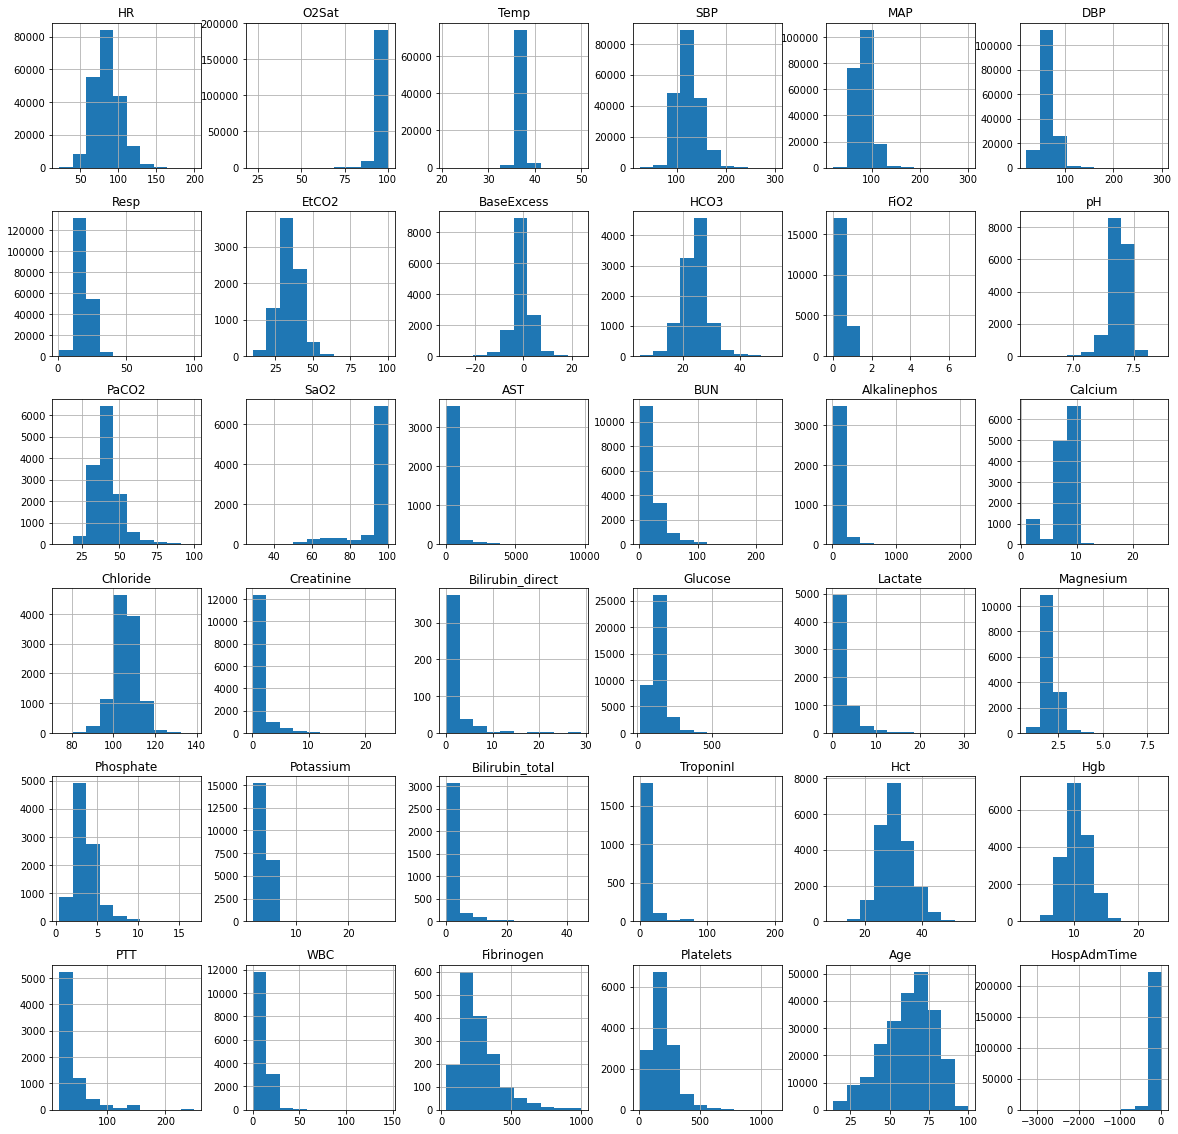

In [9]:
#Distributions for numerical features
raw.drop(labels=['Unit1','Unit2','Gender','SepsisLabel','id','HospitalA','ICULOS'],axis=1).hist(figsize=(20,20))
plt.show()

### 3.c Characterizing Missingness <a class="anchor" id="3.c.CharacterizingMissingness"></a>

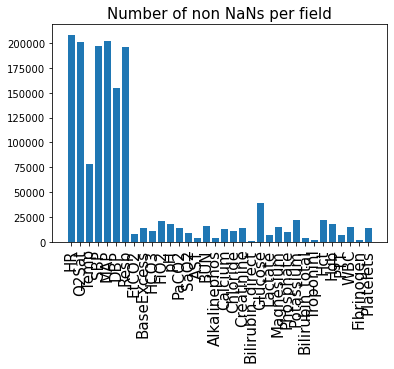

In [10]:
#Plot the Number of NaNs per field for all fields, across all patient entries
#Remove demographic columns
raw_b=raw.drop(labels=['Age','Gender','SepsisLabel','ICULOS','HospAdmTime','id','HospitalA','Unit1','Unit2'],axis=1)
labels=raw_b.columns.tolist()
#Calculate na sums, remove demographic columns
a=[raw_b[col].notna().sum() for col in labels]

plt.bar(labels,a)
plt.rcParams['figure.figsize'] = (20,10)
plt.xticks(labels,fontsize=15,rotation=90)
plt.title('Number of non NaNs per field',fontsize=15)
plt.show()

This plot indicates there are many NaNs in the laboratory fields. However, this is not surprising - since their is patient data hourly, you wouldn't expect lab data every hour. What would be more insightful is to know per patient, is there at least one laboratory value available. 

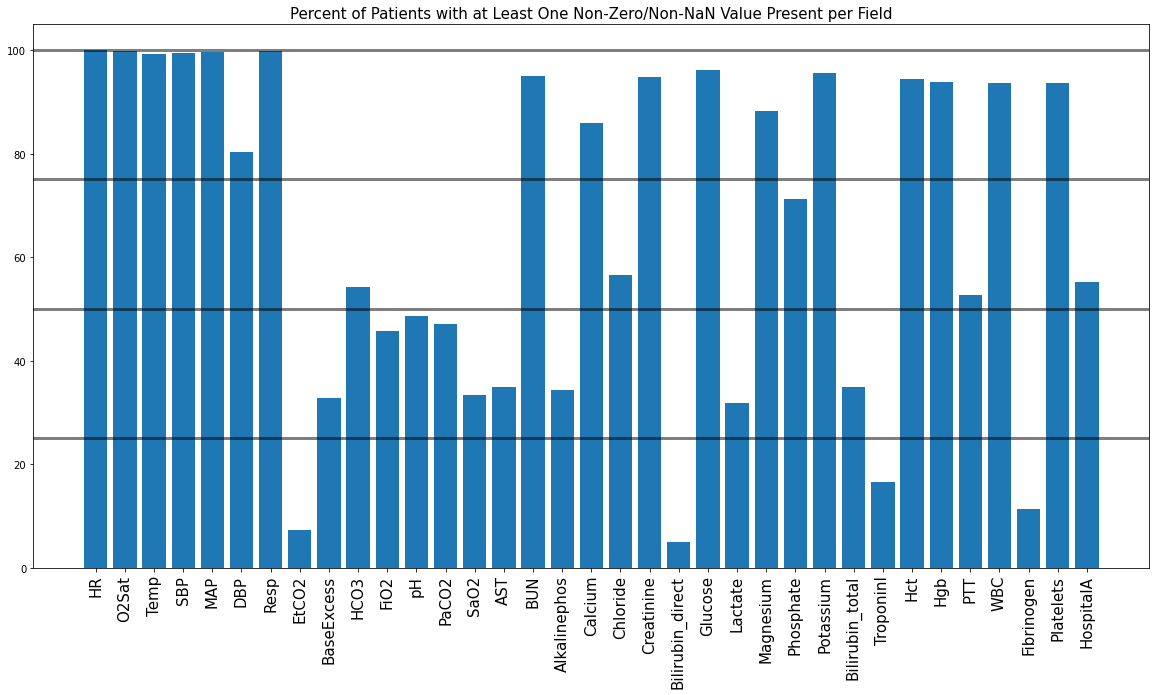

In [11]:
#For each field, plot the percentage of patients with at least one non-zero/NaN value present
n=raw['id'].nunique()
#Remove demographic columns
missing_by_id=raw.groupby(['id']).sum().drop(labels=['Age','Gender','SepsisLabel','ICULOS','HospAdmTime','Unit1','Unit2'],axis=1)
labels_=missing_by_id.columns.tolist()
d=defaultdict(int)
d_={}
for i in labels_:
    for j in range(0,n):
        if missing_by_id.loc[j,i]==0:
            d[i]+=1
    d_[i]=(1-d[i]/n)*100
    
plt.bar(d_.keys(),d_.values())
plt.rcParams['figure.figsize'] = (20,10)
plt.xticks(labels_,fontsize=15,rotation=90)
plt.axhline(25,c='black',lw=3,alpha=0.5)
plt.axhline(50,c='black',lw=3,alpha=0.5)
plt.axhline(75,c='black',lw=3,alpha=0.5)
plt.axhline(100,c='black',lw=3,alpha=0.5)
plt.title('Percent of Patients with at Least One Non-Zero/Non-NaN Value Present per Field',fontsize=15)
plt.show()

This plot shows that many lab values are not present in a majority of patients - not surprising because you would not expect each compund to be tested for everytime. But the missing values are good to keep in mind. Next I want to check the missingness by hospital.

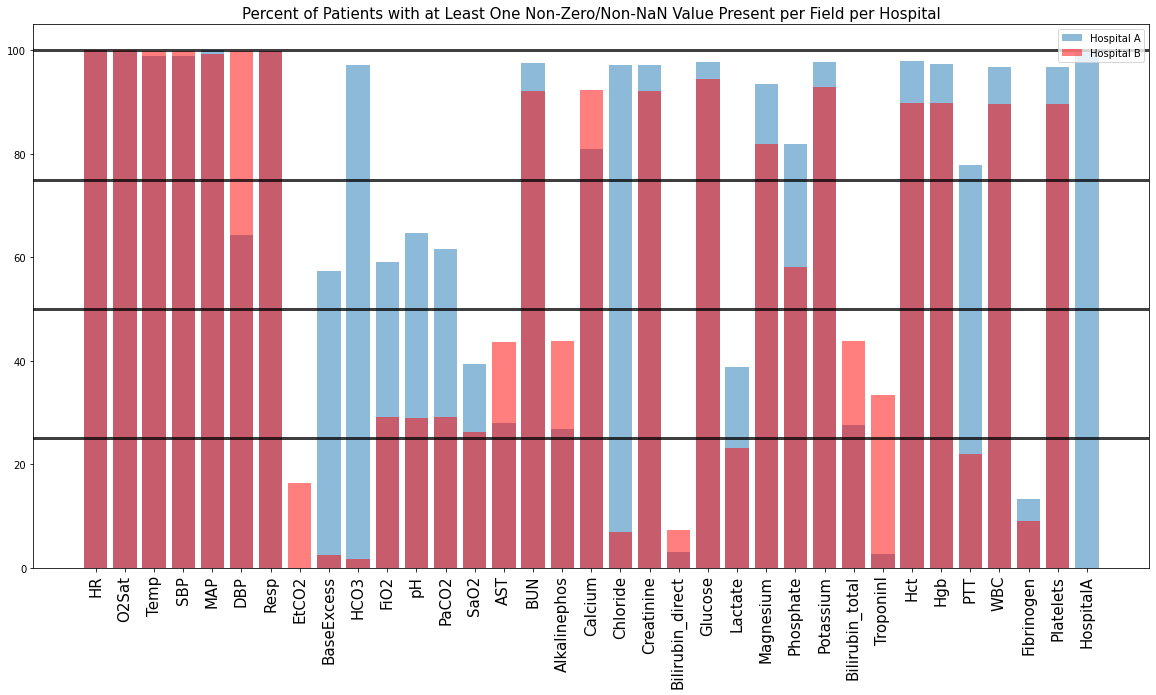

In [12]:
#For each field and hospital, plot the percentage of patients with at least one non-zero/NaN value present
missing_by_id_A=missing_by_id[missing_by_id.HospitalA>0].copy()
nA=len(missing_by_id_A.index)
labels_=missing_by_id_A.columns.tolist()

d=defaultdict(int)
d_={}
for i in labels_:
    for j in range(0,nA):
        if missing_by_id_A.loc[j,i]==0:
            d[i]+=1
    d_[i]=(1-d[i]/nA)*100
plt.bar(d_.keys(),d_.values(),alpha=0.5,label='Hospital A')
plt.rcParams['figure.figsize'] = (20,10)
plt.xticks(labels_,fontsize=15,rotation=90)
plt.axhline(25,c='black',lw=3,alpha=0.5)
plt.axhline(50,c='black',lw=3,alpha=0.5)
plt.axhline(75,c='black',lw=3,alpha=0.5)
plt.axhline(100,c='black',lw=3,alpha=0.5)
plt.title('Percent of patients with at least one value present per field at Hospital A',fontsize=15)

missing_by_id_B=missing_by_id[missing_by_id.HospitalA==0].copy()
nA=len(missing_by_id_A.index)
nB=len(missing_by_id_B.index)
d=defaultdict(int)
d_={}
for i in labels_:
    for j in range(nA,nB+nA):
        if missing_by_id_B.loc[j,i]==0:
            d[i]+=1
    d_[i]=(1-d[i]/nB)*100
plt.bar(d_.keys(),d_.values(),alpha=0.5,label='Hospital B',color='red')
plt.rcParams['figure.figsize'] = (20,10)
plt.xticks(labels_,fontsize=15,rotation=90)
plt.axhline(25,c='black',lw=3,alpha=0.5)
plt.axhline(50,c='black',lw=3,alpha=0.5)
plt.axhline(75,c='black',lw=3,alpha=0.5)
plt.axhline(100,c='black',lw=3,alpha=0.5)
plt.title('Percent of Patients with at Least One Non-Zero/Non-NaN Value Present per Field per Hospital',fontsize=15)
plt.legend(loc='upper right')
plt.show()

Hospital B is missing far more lab values than Hospital A its even responsible for all missing values in the DBP vital column. Something to keep in mind for later.

### 4.a Exploring Vital Signs<a class="anchor" id="4.a.ExploringVitalSigns"></a>

In [13]:
#Get 10 highest temperature values & their patient id
raw[['Temp','id']].sort_values(by='Temp',ascending=False)[0:10]

,Temp,id
179981,50.00,4678
99210,41.22,2537
68653,41.17,1757
68654,41.10,1757
98121,41.00,2509
99209,40.89,2537
99211,40.78,2537
97585,40.56,2495
123281,40.56,3169
2581,40.50,70


In [14]:
#The human body cannot possible reach temperatures of 50 degrees celsius - so the 50 degree value is not plausible.
#The second highest is 42.22C, which is plausible
raw.loc[raw['Temp']>45,'Temp']=np.nan

In [15]:
##Get 15 lowest temperature values & their patient id
raw[['Temp','id']].sort_values(by='Temp')[0:15]

,Temp,id
94334,20.90,2420
14218,23.60,371
105926,26.67,2719
96868,26.67,2477
14217,27.90,371
111293,30.22,2865
225379,30.50,5856
78683,30.65,2015
23106,30.80,595
205693,30.80,5326


A patient would need to be hypothermic to have temperatures below 31 degrees celsius - a clinician would not purposefully set a patient's body temperature below 88 degrees, according to SICU contact. Below I'll plot the time course for patients with at least one temperature value below 31 - if they seem to be outliers within a patient's own range, will mark those values as NaNs for the patient. 

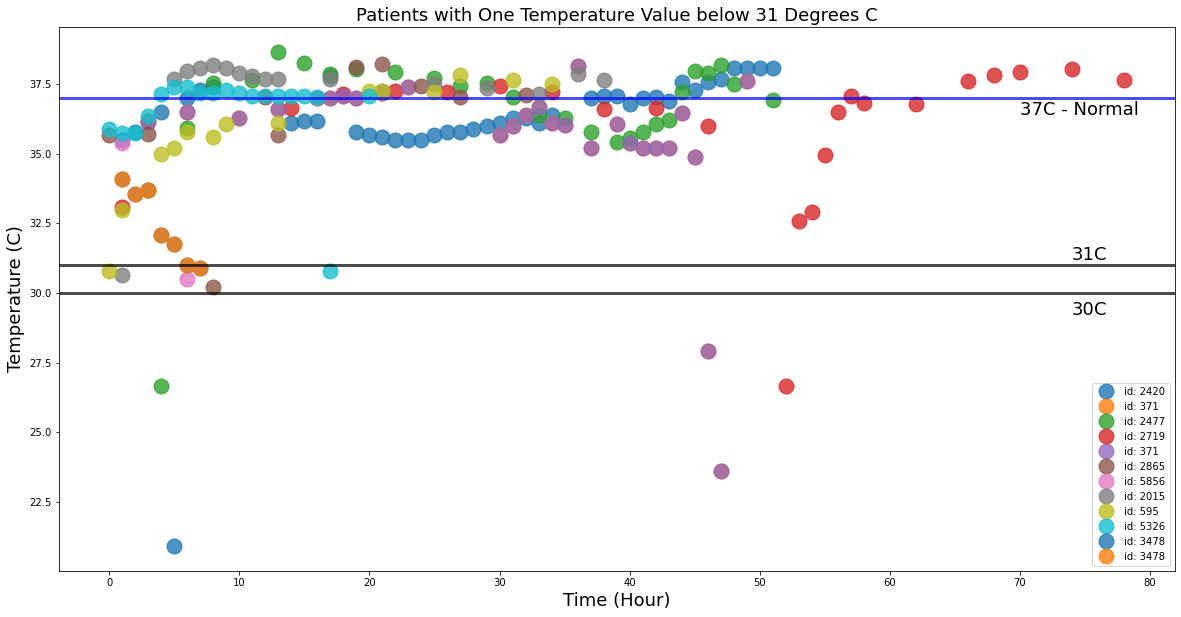

In [16]:
Low_Temp=raw[['Temp','id']].loc[raw.Temp<=31].sort_values(by='Temp')
Low_Temp_id=Low_Temp['id'].values

for i in Low_Temp_id:
    y_=raw[['Temp','id']].loc[raw.id==i]
    y=y_['Temp'].reset_index(drop=True)
    plt.plot(y,marker='.',linestyle='none',markersize=30,alpha=0.8,label='id: '+ str(i))
plt.axhline(31,c='black',lw=3,alpha=0.7)
plt.text(74,31.2,'31C',size=18)
plt.axhline(30,c='black',lw=3,alpha=0.7)
plt.text(74,29.2,'30C',size=18)
plt.axhline(37,c='blue',lw=3,alpha=0.7)
plt.text(70,36.4,'37C - Normal',size=18)
plt.xlabel('Time (Hour)',size=18)
plt.ylabel('Temperature (C)',size=18)
plt.title('Patients with One Temperature Value below 31 Degrees C',size=18)
plt.legend(loc='lower right')
plt.show()

In [17]:
#There is a cluster of points between 30 and 31 degrees for some patients in their initial hours - maybe they were 
#hypothermic when they got to the hopsital. Below 30 degrees, the points get quite random. Will mark only the values 
#less than 30 as NaN. 
raw.loc[raw['Temp']<30,'Temp']=np.nan

In [18]:
#Get 20 highest respiration values & their patient id
raw[['Resp','id']].sort_values(by='Resp',ascending=False)[0:20]
#I would think 100 breaths/minute would not be possible, but these values are not exactly out on their own. 
#Will leave as is. 

,Resp,id
135193,100.0,3487
176060,100.0,4563
152865,99.0,3956
208416,99.0,5399
205695,99.0,5326
169818,97.0,4408
167653,97.0,4353
183653,97.0,4768
142459,96.0,3678
174384,96.0,4522


In [19]:
#Get 20 lowest respiration values & their patient id
raw[['Resp','id']].sort_values(by='Resp')[0:20]
#Again, I would think 1 breaths/minute would not be possible, but these values are not exactly out on their own. 
#Will leave as is. 

,Resp,id
197901,1.0,5128
187009,1.0,4849
162789,1.0,4227
195920,1.0,5084
195921,1.0,5084
187005,1.0,4849
202544,1.0,5243
202546,1.0,5243
130651,1.0,3359
213868,1.0,5544


In [20]:
#O2Sat field - Oxygen Saturation %
#Get 20 lowest O2Sat values & their patient id
raw[['O2Sat','id']].sort_values(['O2Sat'])[0:20]
#This is a long tailed distribution (to the left). O2 sat values less than 50 should not be compatible with life. 
#These lower values may be indicative of poor pulse oximeter performance; they are known to
#perform extremely well when O2 Sat values are high, worse when they are lower. 

,O2Sat,id
99899,22.0,2557
160953,23.0,4176
34562,23.0,890
34563,24.0,890
206518,24.0,5348
99898,25.0,2557
61369,25.0,1575
54229,25.0,1393
80321,25.0,2061
181874,26.0,4725


Below I'll plot the time course for patients with at least one O2Sat value below 25% to further investigate.

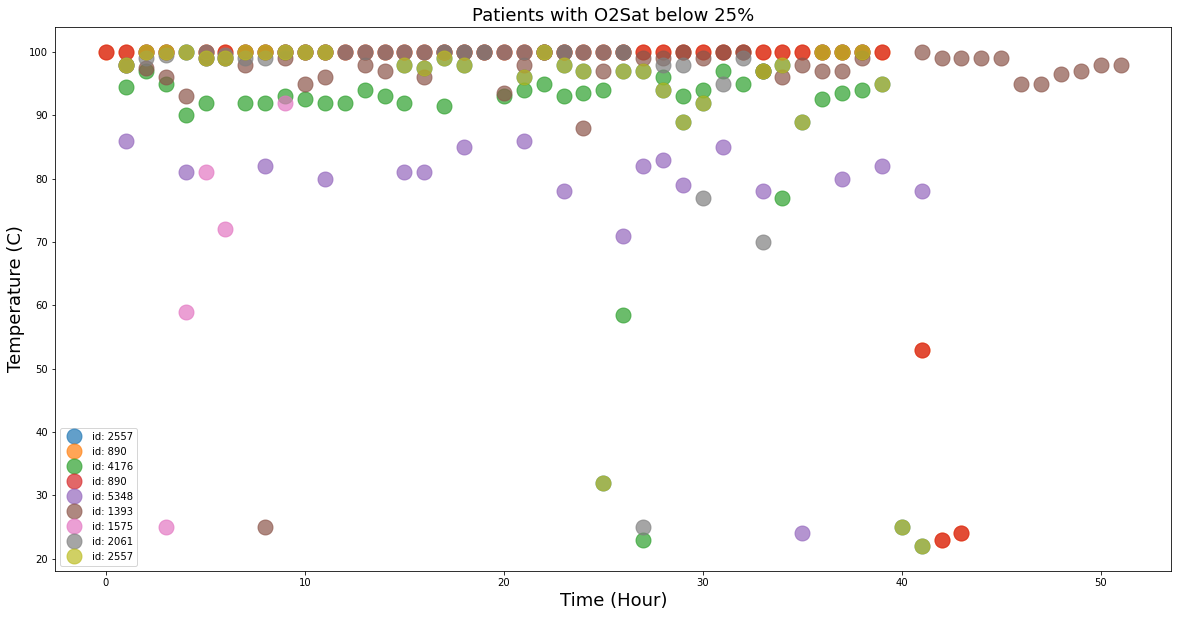

In [21]:
Low_O2Sat=raw[['O2Sat','id']].loc[raw.O2Sat<=25].sort_values(by='O2Sat')
Low_O2Sat_id=Low_O2Sat['id'].values

for i in Low_O2Sat_id:
    y_=raw[['O2Sat','id']].loc[raw.id==i]
    y=y_['O2Sat'].reset_index(drop=True)
    plt.plot(y,marker='.',linestyle='none',markersize=30,alpha=0.7,label='id: '+ str(i))
plt.xlabel('Time (Hour)',size=18)
plt.ylabel('Temperature (C)',size=18)
plt.title('Patients with O2Sat below 25%',size=18)
plt.legend(loc='lower left')
plt.show()

Most of these patients are obviously quite sick (e.g. 890, 2557, 5248) but someone like 1393 could just have an outlying, incorrect reading? Hard to tell. Will leave as is.

In [22]:
#DBP values cannot be greater than or equal to SBP. Let's see if any are.
r=(raw[['DBP','SBP','MAP']].loc[raw.DBP.values>=raw.SBP.values])
r

,DBP,SBP,MAP
2384,287.0,97.0,77.67
6555,130.0,127.0,58.00
10404,115.5,112.5,75.00
16125,166.5,164.0,68.33
47110,80.0,74.0,33.00
56410,132.0,119.0,70.00
58567,66.0,64.0,70.33
60742,88.0,69.0,24.00
102452,137.0,136.0,91.00
118272,74.0,71.6,96.00


In [23]:
#Instances where DBP>SBP will be changed to NaN. Confirm that no incorrect values remain.
raw.loc[r.index,['DBP','SBP','MAP']]=np.nan
raw[['DBP','SBP','MAP']].loc[raw.DBP.values>raw.SBP.values]

,DBP,SBP,MAP


In [24]:
#Now Let's explore blood pressure values and patient id, sorted by each type of BP. First up, Mean Arterial Pressure.
raw[['DBP','SBP','MAP','id']].sort_values(by='MAP',ascending=False)[0:10]

,DBP,SBP,MAP,id
104857,NaN,NaN,295.0,2693
14523,47.0,131.0,294.0,377
194337,66.0,122.0,290.0,5042
46550,57.0,112.0,288.0,1200
170147,76.0,130.0,288.0,4414
166570,142.0,192.0,280.0,4323
133067,75.0,142.0,280.0,3426
46551,64.0,155.0,280.0,1200
206731,78.0,128.0,280.0,5352
133068,70.0,127.0,280.0,3426


In [25]:
#Next up is Diastolic
raw[['DBP','SBP','MAP']].sort_values(by='DBP',ascending=False)[0:10]
#Diastolic cannot possibly be larger than systolic. Something wrong here. 

,DBP,SBP,MAP
215670,188.0,248.0,213.0
162207,184.0,192.0,188.0
211828,182.0,204.0,222.0
141449,174.0,184.0,180.0
34894,173.0,180.0,173.0
221804,169.0,170.0,169.0
50120,168.0,177.0,171.0
219481,167.0,213.0,198.0
115949,162.0,170.0,63.0
130166,160.0,193.0,170.0


In [26]:
#Finally, Systolic
raw[['DBP','SBP','MAP']].sort_values(by='SBP',ascending=False)[0:10]

,DBP,SBP,MAP
226290,84.0,272.0,137.0
226330,84.0,265.0,117.0
169257,64.0,262.0,108.0
218151,80.0,261.0,121.5
226237,88.0,259.0,138.0
226238,91.0,256.0,144.0
226244,79.5,252.0,130.5
142203,128.0,252.0,178.0
226236,83.0,252.0,131.0
169255,64.0,252.0,104.0


These are all plausible ranges. Now I want to check if MAP values follow the standard calculation of MAP=(DBP*2+SBP)/3.

In [27]:
#Calculate MAP values, add new column called 'MAP_Calc'. Drop any rows without BP values.
raw_interim=raw.copy()
raw_interim=raw_interim[['id','DBP','SBP','MAP','HR']]
raw_interim['MAP_Calc']=(raw.SBP+raw.DBP*2)/3
raw_interim.dropna(how='any',axis=0,inplace=True)
raw_interim.reset_index(inplace=True)
raw_interim
 
#Determine which recorded MAP values are outside the range of MAP_Calc +/- 10. 
n=len(raw_interim)
q=np.empty(n)
for i in range(n):
    if (raw_interim.loc[raw_interim.index[i],'MAP']<raw_interim.loc[raw_interim.index[i],'MAP_Calc']+10) and (raw_interim.loc[raw_interim.index[i],'MAP']>raw_interim.loc[raw_interim.index[i],'MAP_Calc']-10):
        q[i]=True
    else:
        q[i]=False
a=np.unique(q,return_counts=True)
a

(array([0., 1.]), array([  6347, 146634], dtype=int64))

4.3% of available MAP values are outside the MAP_Calc +/- 10 range. Won't move on this for now, something to revisit.

### 4.b Exploring Lab Values<a class="anchor" id="4.b.ExploringLabValues"></a>

In [28]:
#TroponinI field
#Get 20 highest TroponinI values & their patient id
raw[['TroponinI','id']].sort_values(by=['TroponinI','id'],ascending=False)[0:20]
#Though this is quite a long tailed distribution, and its curious that so many values are exactly 200; 
#three patients have at least 1 duplicate value of 200. Leave as is. 

,TroponinI,id
153283,200.00,3969
153291,200.00,3969
153307,200.00,3969
150337,200.00,3884
150340,200.00,3884
145488,200.00,3757
144476,200.00,3729
144483,200.00,3729
167772,189.51,4357
152218,169.07,3935


In [29]:
#AST field
#Get 20 highest AST values & their patient id
raw[['AST','id']].sort_values(by='AST',ascending=False)[0:20]
#Though this is quite a long tailed distribution, these outliers are not by themselves. Will leave as is. 

,AST,id
211307,9747.0,5481
169450,9710.0,4399
4443,9640.0,119
41211,9430.0,1059
136143,9229.0,3514
115366,8800.0,2968
115367,8800.0,2968
41216,8780.0,1059
22076,8591.0,572
36342,8377.0,935


In [30]:
#Alkalinephos field
#Get 10 highest Alkalinephos values & their patient id
raw[['Alkalinephos','id']].sort_values(by='Alkalinephos',ascending=False)[0:20]

,Alkalinephos,id
33029,2121.0,849
33028,2121.0,849
33054,1919.0,849
33053,1919.0,849
97351,1204.0,2488
147928,1134.0,3822
36342,1128.0,935
84139,1069.0,2154
39892,1025.0,1028
147964,988.0,3822


In [31]:
#According to a publication (cited in intro), can have Alkalinephos as high as 3,000 U/l in patients with 
#certain diseases, so this is plausible. 
#However, I don't think there is so much information in these higher values, being 13x greater than the median
#I will prevent any values from being greater than 1,000
raw['Alkalinephos']=np.where((raw.Alkalinephos>1000),1000,raw.Alkalinephos)

In [32]:
#Potassium Field
#Get 10 highest Potassium values & their patient id
raw[['Potassium','id']].sort_values(by='Potassium',ascending=False)[0:10]

,Potassium,id
96553,27.5,2469
129229,10.8,3328
55280,10.0,1415
107530,10.0,2763
37912,9.9,977
8154,9.7,215
3127,9.7,83
67576,9.5,1729
33101,9.2,851
107503,9.0,2763


In [33]:
#One big outlier! Will replace with next largest value
raw['Potassium']=np.where((raw.Potassium>15),10.8,raw.Potassium)

In [34]:
#TroponinI Total Field
#Get 30 highest TroponinI values & their patient id
raw[['TroponinI','id']].sort_values(by='TroponinI',ascending=False)[0:30]

,TroponinI,id
153283,200.00,3969
150337,200.00,3884
144476,200.00,3729
144483,200.00,3729
153307,200.00,3969
150340,200.00,3884
145488,200.00,3757
153291,200.00,3969
167772,189.51,4357
152218,169.07,3935


In [35]:
#Replace everything above 100 with 100.
raw['TroponinI']=np.where((raw.TroponinI>100),100,raw.TroponinI)

In [36]:
#WBC Field
#Get 10 highest WBC values & their patient id
raw[['WBC','id']].sort_values(by='WBC',ascending=False)[0:10]

,WBC,id
147516,144.9,3811
56224,128.7,1445
4316,123.1,115
4319,97.1,115
56231,94.8,1445
22178,93.9,574
82901,87.2,2123
56228,81.9,1445
4246,81.3,113
56233,79.5,1445


In [37]:
#Replace everything above 100 with 100.
raw['WBC']=np.where((raw.WBC>100),100,raw.WBC)

In [38]:
#FiO2 field - Fraction of Inspired Oxygen
#Get 10 highest FiO2 values & their patient id
raw[['FiO2','id']].sort_values(by='FiO2',ascending=False)[0:10]

,FiO2,id
125992,7.0,3241
221611,2.0,5753
155750,2.0,4036
184736,1.2,4794
34573,1.0,891
34280,1.0,885
34281,1.0,885
34282,1.0,885
34291,1.0,885
127174,1.0,3274


In [39]:
#FiO2 values cannot possibly be greater than 1 (they are a fraction), 
#so these 4 values greater than 1 will be changed to NaN 
raw.loc[raw['FiO2']>1,'FiO2']=np.nan

### 4.c Exploring Demographic Info<a class="anchor" id="4.c.ExploringDemographicInfo"></a>

In [40]:
#Remind myself the length of the df
len(raw)

231307

In [41]:
#Verifying that Gender only has values of 1 or 0, and there are no NaNs. Looks good. 
G_vc=raw.Gender.value_counts()
G_vc[1]+G_vc[0]-231307

0

In [42]:
#Verifying that Unit1 only has values of 1 or 0
raw.Unit1.value_counts()

0.0    70783
1.0    69882
Name: Unit1, dtype: int64

In [43]:
#Verifying that Unit1 only has values of 1 or 0
raw.Unit2.value_counts()

1.0    70783
0.0    69882
Name: Unit2, dtype: int64

Looks like Unit1 and Unit 2 info are missing for a lot of patients -  this is in line with the missingness bar plot above. So its not clear if some patients are or are not in a certain ICU or another unit altogether - something to keep in mind.

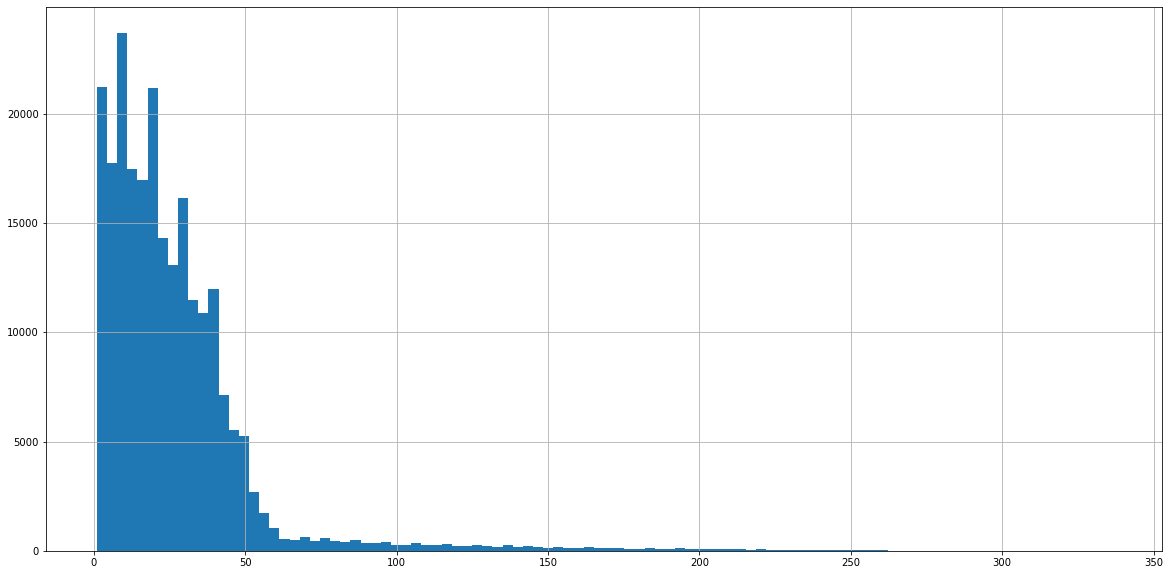

In [44]:
#Histogram of ICULOS field; represents ICU length-of-stay (hours since ICU admit) for all patients, every hour
#No wild outliers here, this field checks out - maximum ICU stay length is about 2 weeks. 
raw.ICULOS.hist(bins=100)
plt.show()

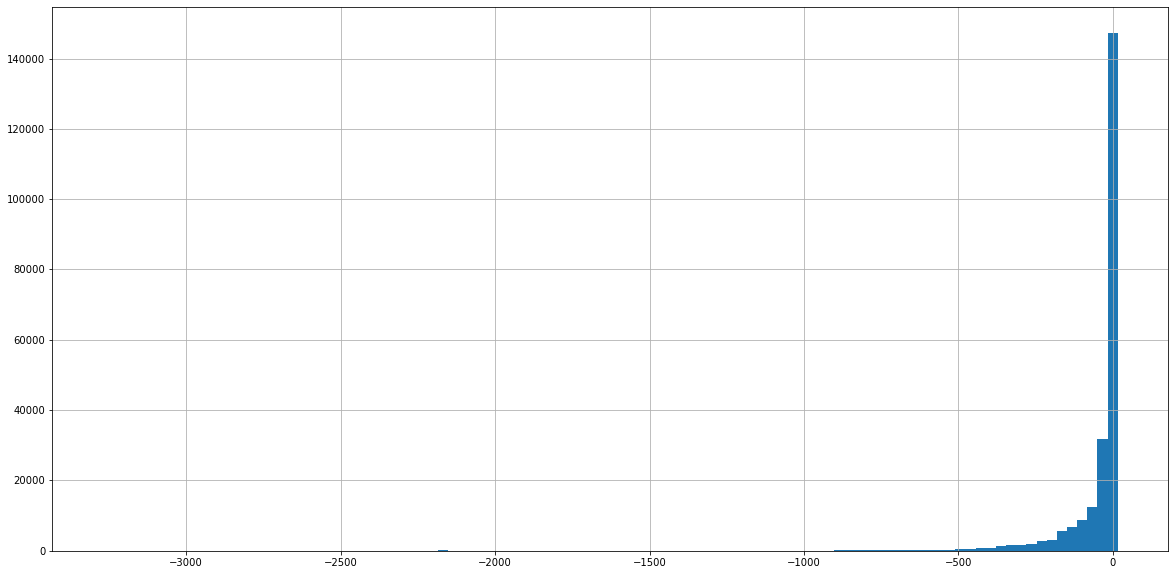

In [45]:
#Histogram of hours between hospital admit and ICU admit
#Some signficant outliers here
raw.HospAdmTime.hist(bins=100)
plt.show()

In [46]:
raw.HospAdmTime.value_counts().sort_index().head(20)

#Some extreme outliers here that don't make sense! 3,200 hours between hospital admit and ICU admit? 
#That is about 1/3 of a year. Not sure what to do with this at this point...

-3269.10     21
-2384.78     29
-2178.36    152
-1786.40     11
-1606.97     10
-1510.72     29
-1471.01     34
-1417.86     83
-1389.93     29
-1280.55     48
-1245.92     58
-1216.39     36
-1195.71     48
-1188.85      8
-1041.78     41
-999.90      22
-989.59      41
-964.27      13
-960.05      41
-951.07       9
Name: HospAdmTime, dtype: int64

In [47]:
#Explore missing demographic values
raw.loc[:,'Age':'SepsisLabel'].isnull().sum().sort_values()

Age                0
Gender             0
HospAdmTime        0
ICULOS             0
SepsisLabel        0
Unit1          90642
Unit2          90642
dtype: int64

In [48]:
#What's going on with Unit 1 & 2?
raw[['Unit1','Unit2','HospitalA']].value_counts()

Unit1  Unit2  HospitalA
0.0    1.0    0            37010
1.0    0.0    1            35352
              0            34530
0.0    1.0    1            33773
dtype: int64

In [49]:
#Fill nans in Unit1 & Unit2 Columns with 0's
raw[['Unit1','Unit2']]=raw[['Unit1','Unit2']].fillna(value=0)

In [50]:
#Explore missing demographic values
raw.loc[:,'Age':'SepsisLabel'].isnull().sum().sort_values()

Age            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
SepsisLabel    0
dtype: int64

### 4.d Distributions - Modified <a class="anchor" id="4.d.Distributions-Modified"></a>

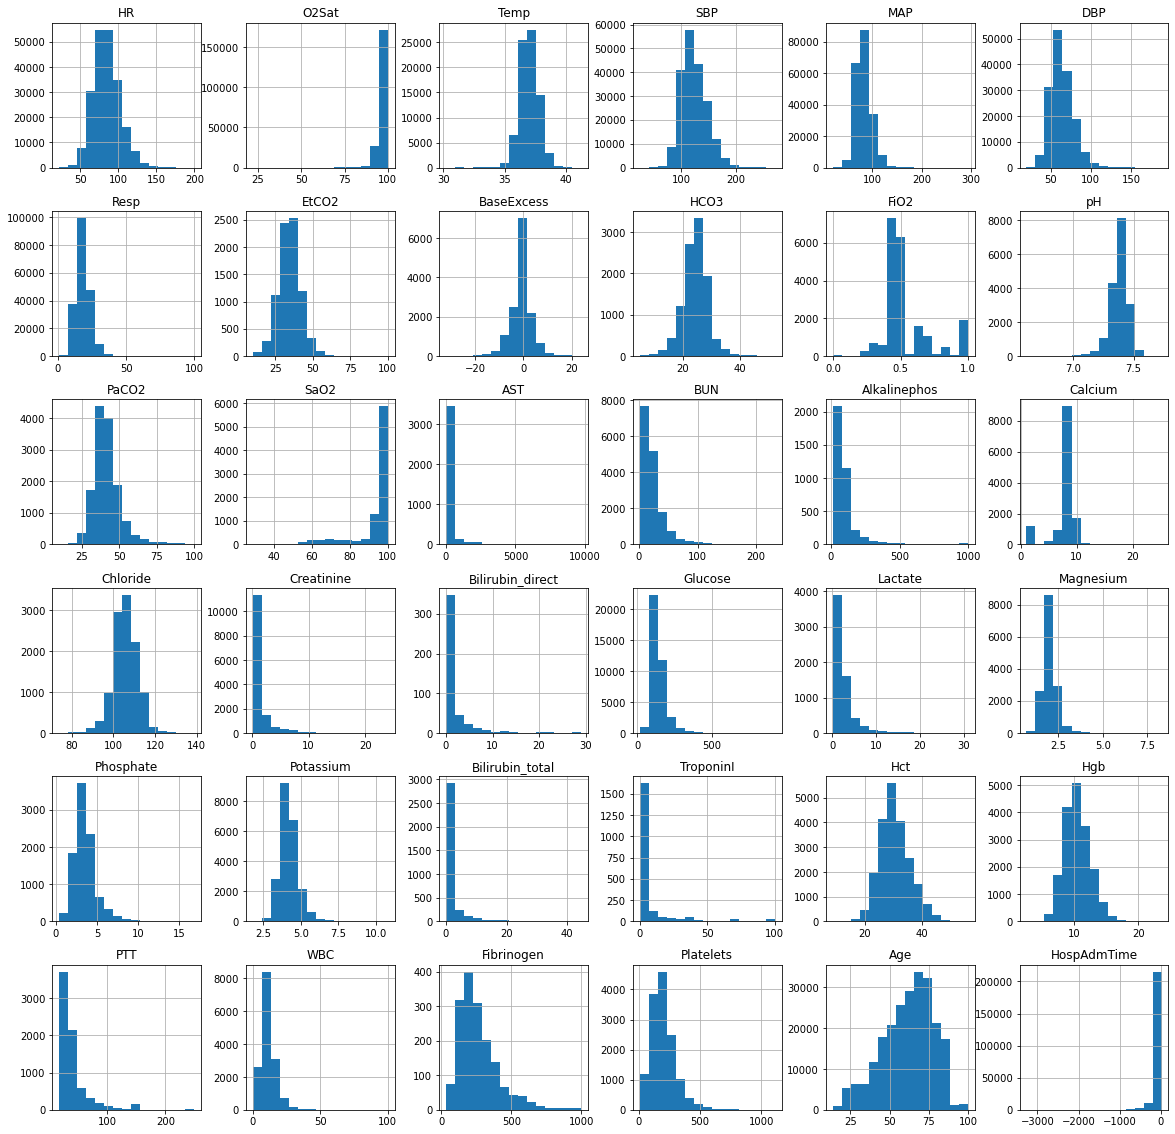

In [51]:
#Plot distributions for numerical features again, with some outliers removed.
raw.drop(labels=['Unit1','Unit2','Gender','SepsisLabel','id','HospitalA','ICULOS'],axis=1).hist(figsize=(20,20),bins=15)
plt.show()

In [52]:
Notes={}
Notes["HR"]='BPM. Range: (22-200). Range is totally plausible. .'
Notes["O2Sat"]='(%). Range:(22 - 100). This is a long tailed distribution (to the left). 22% O2 sat should not be compatible with life. These lower values could be indicative of poor pulse oximeter performance; pulse oxes perform extremely well when O2 Sat values are high, worse when they are lower. Leaving as is. Nonetheless, patients with lowest values do seem to have unhealty levels over all, so I dont think this are wild sensor errors. Leaving as is for now. '
Notes["Temp"]='(Deg C). Current Range: (30 - 41.22). According to SICU contact, clinicians would not reduce a patients temperature below 31 degrees on purpose. Would have to be a hypothermic patient coming from the cold.  Maximum value of 50 degrees was replaced with NaN - The human body cannot possible reach temperatures of 50 degrees celsius. The second highest is 42.22C, which is plausible so left as is. Values less than 30 marked as NaN; a few values between 30-31 plausible as hypothermic patients.'
Notes["SBP"]='(mm Hg). Range:(24 to 300). Cannot <= DBP; instances of that marked NaN.'
Notes["MAP"]='(mm Hg). Range:(20 to 300). Any instance where DBP>=SBP, MAP marked as NaN.'
Notes["DBP"]='(mm Hg). Range:(20 to 300). Cannot be >= to SBP, instances of that marked NaN.'  
Notes["Resp"]='Breath/Min. Range(1 to 100). Would think 100 breaths/minute would not be possible, but there are many patients with values around 100. 1 breath/min is also extremely low, but cannot say its impossible. Will leave as is. '
Notes["EtCO2"]='End tidal carbon dioxide (mm Hg). Range:(10 to 100). Range is totally plausible. Found that in paitents with an ETCO2 of 10mmHg or less, cardiac arrest associated with death (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5827051/#B67)'
Notes["BaseExcess"]="Measure of excess bicarbonate (mmol/L). Range:(-32-24). Indicator of gaseous content of breath. Normal values between -3 and 3. "
Notes["HCO3"]=" (mmol/L). Bicarbonate. Range:(5-52)."
Notes["FiO2"]='	Fraction of inspired oxygen (%). Range:(0-1). 4 FiO2 values were originally more than 1, which is not possible (they are a fraction), so they were changed to NaN'
Notes["pH"]="Commonly collected value. Range:(6.6-7.7). SICU contact says this is completely plausible. pH values of 6 are cause for concern."
Notes["PaCO2"]="Partial pressure of carbon dioxide from arterial blood (mm Hg). Commonly collected value.Range (10-100)."
Notes["SaO2"]="Oxygen saturation from arterial blood (%). Range:(29-100)."
Notes["AST"]="(IU/L). Range:(6-9747). Large Tail, but outliers have a lot of company. Leave as is."
Notes["BUN"]="(mg/dL). Range:(1-232). Commonly collected value. Product of Kidney Function."
Notes["Alkalinephos"]='(IU/L). Range:(14-1000). Product of Liver Function. The healthy range for Alkalinephos is 20 to 140 IU/L, while here the min is 14 and the max is 2121. The patient who has that max value also has the second highest distinct value of 1919. I found a paper that reported up to 3,360.Truncated values over 1000 because they were so few and so dramatic.'
Notes["Calcium"]='(mg/dL). Range:(1-25.2). Commonly collected value.'
Notes["Chloride"]='(mmol/L). Range:(74-139). Distribution looks normal, nothing to change.'
Notes["Creatinine"]='(mg/dL). Range:(0.1-24). Commonly collected value.Product of Kidney Function.'
Notes["Bilirubin_direct"]='(mg/dL). Range:(0.01-29.1). Not a normal thing to ask for; only if liver issues suspected'
Notes["Glucose"]='Serum glucose (mg/dL). Range:(14-924). Commonly collected value. Apparently the greatest ever recorded blood glucose level was 2656 mg/dl, so this column left as is.  '
Notes["Lactate"]='Lactic acid (mg/dL). Range:(0.2-31). Commonly collected value.'
Notes["Magnesium"]='(mmol/dL). Range:(0.7-8.3). Commonly collected value.'
Notes["Phosphate"]='(mg/dL). Range:(0.4-16.9). Commonly collected value.'
Notes["Potassium"]='(mmol/L). Range:(1.8-10.8). Commonly collected value. Removed lone outlier that was had a value greater than 20, made it 10.'
Notes["Bilirubin_total"]=' (mg/dL). Range:(0.1-44.6). Not a normal thing to ask for; only if liver issues suspected'
Notes["TroponinI"]='(ng/mL). Range:(0.01-200). Clinician would only order this if they suspect patient has had/will have a heart attack.This is a long tailed distribution, and its curious that so many values are exactly 200; three patients have at least 1 duplicate value of 200. Leave as is. '
Notes["Hct"]='Hematocrit (%) Range:(8.80-56.4). Commonly collected value.'
Notes["Hgb"]='Hemoglobin (g/dL) Range:(2.6-23.6). Commonly collected value.'
Notes["PTT"]='Partial thromboplastin time (seconds). Range:(17.10-250). Ordered if clinical expects that a patient is bleeding.(?)'
Notes["WBC"]='Leukocyte count (count*10^3/µL). Range:(0.1-144.90). Commonly collected value.'
Notes["Fibrinogen"]='mg/dL. Range:(35-10000). Ordered if clinical expects that a patient is bleeding.(?)'
Notes["Platelets"]='count*10^3/µL. Range:(4-1111).'
Notes["Age"]='In years, 100 for patients 90 or above'
Notes["Gender"]='1 if male, 0 if female'
Notes["Unit1"]='1 for MICU, 0 if not'
Notes["Unit2"]='1 for SICU, 0 if not'
Notes["HospAdmTime"]='Hours between hospital admit and ICU admit'
Notes["ICULOS"]='ICU length-of-stay (hours since ICU admit)'
Notes["SepsisLabel"]='For sepsis patients, SepsisLabel is 1 if t≥tsepsis−6 and 0 if t<tsepsis−6. For non-sepsis patients, SepsisLabel is 0.'
Notes["id"]='(Created by Me) Integer specifying unique patient id for each time point related to that patient.'
Notes["HospitalA"]='(Created by Me) 1 or 0 if patient was at Hopsital A or B, respectively.'

## 5. Data Export<a class="anchor" id="5.DataExport"></a>

In [53]:
#Save the data 
os.chdir('../interim')
pd.DataFrame.to_csv(raw,'sepsis_data_cleaned.csv')

#Save the notes
with open("Data_Notes.json", "w") as outfile:  
    json.dump(Notes, outfile) 